In [25]:
import numpy as np
import geatpy as ea
import random

In [26]:
INDS_LEN = 100
NUM_LIMIT = 10
SUM_CONSTRAINT = 100
POP_SIZE = 5000
GEN_NUM = 500

step_size = 1 / (INDS_LEN / NUM_LIMIT)
block = [round(i * step_size, 3) for i in range(1, INDS_LEN // NUM_LIMIT+1)]
RESULT_LIST = np.array(block * NUM_LIMIT)

In [27]:
def constraint(Vars):
    w_num = np.zeros((Vars.shape[0], 1))
    w_sum = np.zeros((Vars.shape[0], 1))
    
    for i in range(Vars.shape[0]):
        rows = Vars[i, :]
        num_rows = np.where(rows != 0, 1, 0)
        w_num[i] = np.sum(num_rows)
        w_sum[i] = np.sum(rows)
    
    print("====================================CONSTRAINT====================================")
    print("------------------------------------Vars------------------------------------")
    print(Vars)
    print("------------------------------------NUM------------------------------------")
    print(np.abs(w_num - NUM_LIMIT))
    print("------------------------------------SUM------------------------------------")
    print(np.abs(w_sum - SUM_CONSTRAINT))
    
    return w_num, w_sum


In [28]:
class MyProblem(ea.Problem):
    
    def __init__(self):
        name = 'MyProblem'
        M = 1
        maxormins = [-1]
        Dim = INDS_LEN
        varTypes = [1] * Dim
        lb = [ 0 for _ in range(INDS_LEN)]
        ub = [ 100 for _ in range(INDS_LEN)]
        lbin = [ 1 for _ in range(INDS_LEN)]
        ubin = [ 1 for _ in range(INDS_LEN)]
        
        ea.Problem.__init__(self,
                            name,
                            M,
                            maxormins,
                            Dim,
                            varTypes,
                            lb,
                            ub,
                            lbin,
                            ubin)
    
    def evalVars(self, Vars):
        f = np.ones((Vars.shape[0], 1))
        
        for i in range(Vars.shape[0]):
            rows = Vars[i, :]
            filtered_result_list = RESULT_LIST[rows != 0]
            filtered_rows = rows[rows != 0]
            f[i] = np.prod(filtered_rows * filtered_result_list)
        
        CV = np.hstack(
            [np.abs(constraint(Vars)[0] - NUM_LIMIT), np.abs(constraint(Vars)[1] - SUM_CONSTRAINT)])
        
        return f, CV

In [29]:
def create_individual():
    individual = [0] * INDS_LEN

    chosen_positions = random.sample(range(INDS_LEN), NUM_LIMIT)

    remaining = SUM_CONSTRAINT
    for i in range(NUM_LIMIT-1):
        individual[chosen_positions[i]] = random.randint(1, remaining - (NUM_LIMIT - (i + 1)))
        remaining -= individual[chosen_positions[i]]
    individual[chosen_positions[-1]] = remaining

    return individual

def init_pop():
    population = []
    for _ in range(POP_SIZE):
        individual = create_individual()
        population.append(individual)
    return np.array(population)

pop = init_pop()
print(pop)

[[ 2  0  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 72]
 [ 0  0  0 ...  0  2  3]]


====================================CONSTRAINT====================================
------------------------------------Vars------------------------------------
[[23 43  9 ... 44 12 10]
 [28 11 89 ...  6 24 43]
 [12 60 13 ... 84 38 17]
 ...
 [73 65 86 ... 37 20 34]
 [79  8  2 ...  5 98 18]
 [86 65 30 ... 71 83 13]]
------------------------------------NUM------------------------------------
[[88.]
 [90.]
 [90.]
 ...
 [88.]
 [89.]
 [90.]]
------------------------------------SUM------------------------------------
[[4906.]
 [5217.]
 [5066.]
 ...
 [5047.]
 [5055.]
 [5283.]]
====================================CONSTRAINT====================================
------------------------------------Vars------------------------------------
[[23 43  9 ... 44 12 10]
 [28 11 89 ...  6 24 43]
 [12 60 13 ... 84 38 17]
 ...
 [73 65 86 ... 37 20 34]
 [79  8  2 ...  5 98 18]
 [86 65 30 ... 71 83 13]]
------------------------------------NUM------------------------------------
[[88.]
 [90.]
 [90.]
 ...
 [88.]

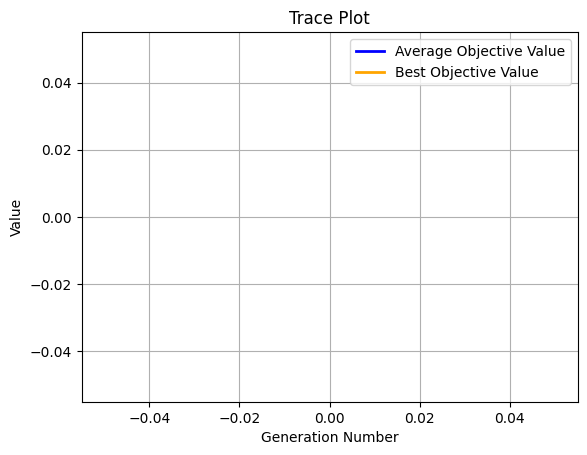

Execution time: 122.95201826095581 s
Evaluation number: 2500000
Optimization fail: Could not find any feasible solution.


KeyError: 'f_opt'

In [30]:
if __name__ == "__main__":
    problem = MyProblem()
    
    algorithm = ea.soea_DE_currentToBest_1_bin_templet(
        problem,
        ea.Population(Encoding='RI', NIND=POP_SIZE, Chrom=pop),
        MAXGEN=GEN_NUM,
        logTras=100
    )
    
    algorithm.mutOper.F = 0.7
    algorithm.recOper.XOVR = 0.7
    
    res = ea.optimize(
        algorithm,
        verbose=True,
        drawing=1,
        outputMsg=True,
        drawLog=True
    )
    
    print(res)